In [8]:
import pickle
import sklearn
import pandas
import numpy
import shap
import matplotlib
matplotlib.__version__
shap.__version__
numpy.__version__
# pandas.__version__
sklearn.__version__

NameError: name 'python' is not defined

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
import pickle
from matplotlib import pyplot as plt

In [2]:
file = "../../data/raw/ENB2012_data.csv"
df = pd.read_csv(file)
X = df.drop(columns=['Y1', 'Y2'], axis=1)
y1 = df['Y1']
y2 = df['Y2']

In [3]:
cat_ftrs = ['X6','X8']
num_ftrs = ['X1','X2','X3','X4','X5','X7']
target_ftrs = ['Y1', 'Y2']

## MinMaxScaler for num_ftrs
scaler = MinMaxScaler()
num_transformer = make_pipeline(scaler)
## One-hot encoding for cat_ftrs
ohe = OneHotEncoder(sparse=False, categories="auto")
cat_transformer = make_pipeline(ohe)

## Create a preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_ftrs),
    ('cat', cat_transformer, cat_ftrs)
])

In [4]:
def ML_pipeline_GridSearchCV_kfold(X, y, seed, n_folds, 
                                 reg, param_grid):
    ## reg: the regressor
    ## param_grid: hyperparameters to be tuned
    X_other, X_test, y_other, y_test = train_test_split(X, y, 
                   test_size=0.2, random_state=seed)
    kf = KFold(n_splits=n_folds) # no need to shuffle again
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', reg)])
    grid = GridSearchCV(pipe, param_grid=param_grid,
                        cv=kf, iid=False, scoring=\
        make_scorer(r2_score))
#         make_scorer(mean_squared_error, greater_is_better=False))
    grid.fit(X_other, y_other)
    return grid, X_test, y_test

### Lasso linear regression

In [12]:
from sklearn.linear_model import Lasso

In [13]:
lasso = Lasso(max_iter=10000)
param_grid = {'regressor__alpha': np.logspace(-4, 2, 11)}
grid, X_test, y_test = ML_pipeline_GridSearchCV_kfold(X, y1, 
      seed=42, n_folds=5, reg=lasso, param_grid=param_grid)

In [14]:
import pickle

In [15]:
print(grid.best_score_)
print(grid.score(X_test,y_test))
print(grid.best_params_)

# save the output so I can use it later
file = open('../../results/lasso_grid.save', 'wb')
pickle.dump((grid,X_test,y_test),file)
file.close()

-0.9205335043078614
-0.9207987264486405
{'regressor__alpha': 0.00039810717055349735}


In [25]:
file = open('../../results/lasso_grid.save', 'rb')
grid, X_test, y_test = pickle.load(file)
file.close()

nr_runs = 10
ftr_names = X_test.columns
scores = np.zeros([len(ftr_names),nr_runs])

test_score = grid.score(X_test,y_test)
print('test score = ',test_score)
print('test baseline = 0')
# loop through the features
for i in range(len(ftr_names)):
    print('shuffling '+str(ftr_names[i]))
    r2_scores = []
    for j in range(nr_runs):
        X_test_shuffled = X_test.copy()
        X_test_shuffled[ftr_names[i]] = np.random.permutation(X_test[ftr_names[i]].values)
        r2_scores.append(grid.score(X_test_shuffled,y_test))
    print('   shuffled test score:',np.around(np.mean(r2_scores),3),'+/-',np.around(np.std(r2_scores),3))
    scores[i] = r2_scores

test score =  0.9207987264486405
test baseline = 0
shuffling X1
   shuffled test score: 0.129 +/- 0.083
shuffling X2
   shuffled test score: 0.852 +/- 0.009
shuffling X3
   shuffled test score: 0.921 +/- 0.0
shuffling X4
   shuffled test score: 0.339 +/- 0.045
shuffling X5
   shuffled test score: -0.161 +/- 0.064
shuffling X6
   shuffled test score: 0.921 +/- 0.0
shuffling X7
   shuffled test score: 0.837 +/- 0.01
shuffling X8
   shuffled test score: 0.903 +/- 0.002


In [19]:
from matplotlib import pyplot as plt

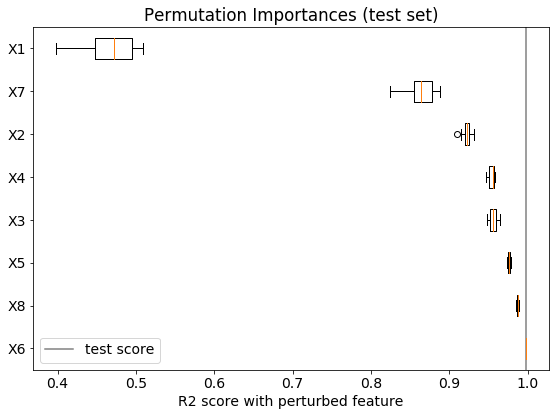

In [14]:
sorted_indcs = np.argsort(np.mean(scores,axis=1))[::-1]
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,6))
plt.boxplot(scores[sorted_indcs].T,labels=ftr_names[sorted_indcs],vert=False)
plt.axvline(test_score,label='test score' ,color='grey')
plt.title("Permutation Importances (test set)")
plt.xlabel('R2 score with perturbed feature')
plt.legend()
plt.tight_layout()
plt.show()

### RandomForest regression

In [5]:
from sklearn.ensemble import RandomForestRegressor

In [6]:
rfr = RandomForestRegressor(random_state=42, n_estimators=20)
max_depths = [int(x) for x in np.linspace(2, 50, num=10)]
min_samples_splits = range(2, 12, 2)
param_grid_rfr = { "regressor__max_depth" : max_depths, 
               "regressor__min_samples_split" : min_samples_splits }
# Y1
grid, X_test, y_test = ML_pipeline_GridSearchCV_kfold(X, y1, 
      seed=42, n_folds=5, reg=rfr, param_grid=param_grid_rfr)
# Y2
grid_2, X_test_2, y_test_2 = ML_pipeline_GridSearchCV_kfold(X, y2, 
      seed=42, n_folds=5, reg=rfr, param_grid=param_grid_rfr)

In [9]:
print(grid.best_score_)
print(grid.score(X_test,y_test))
print(grid.best_params_)

# save the output so I can use it later
file = open('../../results/randomforestregressor_grid_Y1.save', 'wb')
pickle.dump((grid,X_test,y_test),file)
file.close()

0.9971031215158795
0.9975128256079665
{'regressor__max_depth': 7, 'regressor__min_samples_split': 2}


In [10]:
print(grid_2.best_score_)
print(grid_2.score(X_test_2,y_test_2))
print(grid_2.best_params_)

# save the output so I can use it later
file = open('../../results/randomforestregressor_grid_Y2.save', 'wb')
pickle.dump((grid_2,X_test_2,y_test_2),file)
file.close()

0.9643540848898413
0.9600032734932054
{'regressor__max_depth': 7, 'regressor__min_samples_split': 2}


In [15]:
file = open('../../results/randomforestregressor_grid_Y1.save', 'rb')
grid, X_test, y_test = pickle.load(file)
file.close()

nr_runs = 10
ftr_names = X_test.columns
scores = np.zeros([len(ftr_names),nr_runs])

test_score = grid.score(X_test,y_test)
print('test score = ',test_score)
print('test baseline = 0')
# loop through the features
for i in range(len(ftr_names)):
    print('shuffling '+str(ftr_names[i]))
    r2_scores = []
    for j in range(nr_runs):
        X_test_shuffled = X_test.copy()
        X_test_shuffled[ftr_names[i]] = np.random.permutation(X_test[ftr_names[i]].values)
        r2_scores.append(grid.score(X_test_shuffled,y_test))
    print('   shuffled test score:',np.around(np.mean(r2_scores),3),'+/-',np.around(np.std(r2_scores),3))
    scores[i] = r2_scores

test score =  0.9975128256079665
test baseline = 0
shuffling X1
   shuffled test score: 0.49 +/- 0.024
shuffling X2
   shuffled test score: 0.919 +/- 0.006
shuffling X3
   shuffled test score: 0.955 +/- 0.003
shuffling X4
   shuffled test score: 0.954 +/- 0.005
shuffling X5
   shuffled test score: 0.976 +/- 0.002
shuffling X6
   shuffled test score: 0.998 +/- 0.0
shuffling X7
   shuffled test score: 0.866 +/- 0.013
shuffling X8
   shuffled test score: 0.988 +/- 0.001


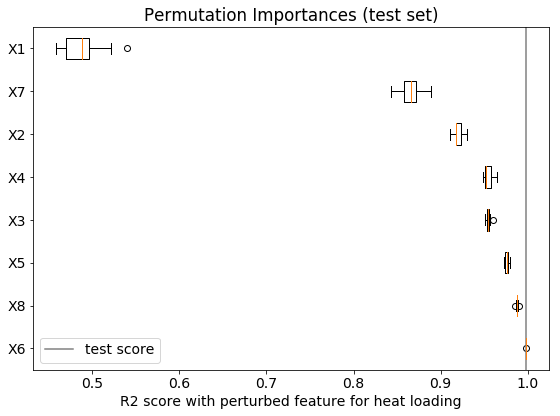

In [16]:
sorted_indcs = np.argsort(np.mean(scores,axis=1))[::-1]
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,6))
plt.boxplot(scores[sorted_indcs].T,labels=ftr_names[sorted_indcs],vert=False)
plt.axvline(test_score,label='test score' ,color='grey')
plt.title("Permutation Importances (test set)")
plt.xlabel('R2 score with perturbed feature for heat loading')
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
file = open('../../results/randomforestregressor_grid_Y2.save', 'rb')
grid_2, X_test_2, y_test_2 = pickle.load(file)
file.close()

nr_runs = 10
ftr_names = X_test_2.columns
scores = np.zeros([len(ftr_names),nr_runs])

test_score = grid_2.score(X_test_2,y_test_2)
print('test score = ',test_score)
print('test baseline = 0')
# loop through the features
for i in range(len(ftr_names)):
    print('shuffling '+str(ftr_names[i]))
    r2_scores = []
    for j in range(nr_runs):
        X_test_shuffled = X_test_2.copy()
        X_test_shuffled[ftr_names[i]] = np.random.permutation(X_test_2[ftr_names[i]].values)
        r2_scores.append(grid.score(X_test_shuffled,y_test_2))
    print('   shuffled test score:',np.around(np.mean(r2_scores),3),'+/-',np.around(np.std(r2_scores),3))
    scores[i] = r2_scores

test score =  0.9600032734932054
test baseline = 0
shuffling X1
   shuffled test score: 0.403 +/- 0.059
shuffling X2
   shuffled test score: 0.839 +/- 0.005
shuffling X3
   shuffled test score: 0.865 +/- 0.007
shuffling X4
   shuffled test score: 0.869 +/- 0.004
shuffling X5
   shuffled test score: 0.891 +/- 0.003
shuffling X6
   shuffled test score: 0.896 +/- 0.0
shuffling X7
   shuffled test score: 0.79 +/- 0.014
shuffling X8
   shuffled test score: 0.902 +/- 0.002


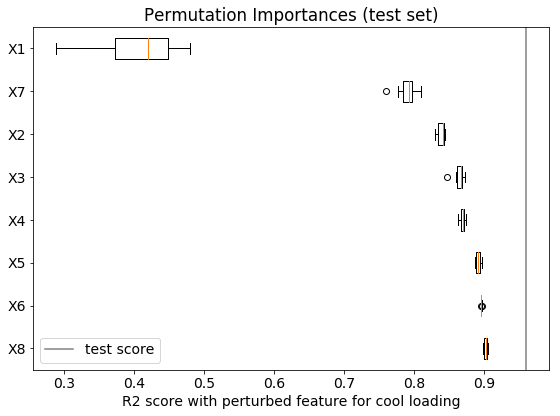

In [18]:
sorted_indcs = np.argsort(np.mean(scores,axis=1))[::-1]
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,6))
plt.boxplot(scores[sorted_indcs].T,labels=ftr_names[sorted_indcs],vert=False)
plt.axvline(test_score,label='test score' ,color='grey')
plt.title("Permutation Importances (test set)")
plt.xlabel('R2 score with perturbed feature for cool loading')
plt.legend()
plt.tight_layout()
plt.show()

### Local feature importance

In [19]:
import shap
shap.initjs() # required for visualizations later on

In [20]:
# create the explainer object with the random forest model
explainer = shap.TreeExplainer(grid.best_estimator_[1])
X_test_transformed = grid.best_estimator_[0].transform(X_test)
shap_values = explainer.shap_values(X_test_transformed)
print(np.shape(shap_values))

(154, 16)


In [25]:
# create the explainer object with the random forest model
explainer_2 = shap.TreeExplainer(grid_2.best_estimator_[1])
X_test_transformed_2 = grid_2.best_estimator_[0].transform(X_test_2)
shap_values_2 = explainer_2.shap_values(X_test_transformed_2)
print(np.shape(shap_values_2))

(154, 16)


In [21]:
print(X_test_transformed_2.shape)
feature_names =  num_ftrs + \
                list(grid.best_estimator_[0].named_transformers_['cat'][0].get_feature_names(cat_ftrs))

(154, 16)


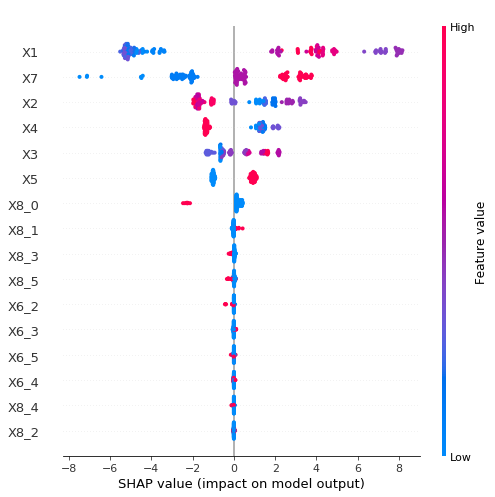

In [22]:
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names)

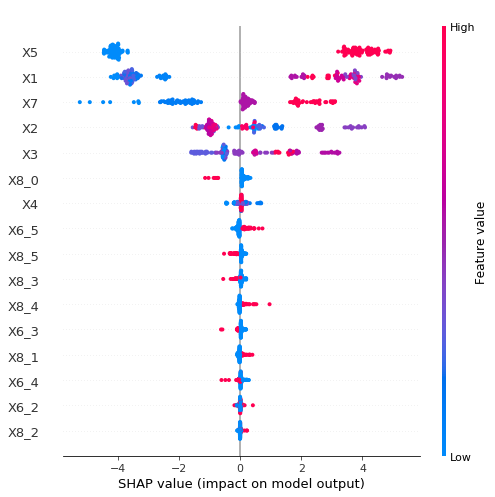

In [26]:
shap.summary_plot(shap_values_2, X_test_transformed_2, feature_names=feature_names)

### Support vector regression

In [55]:
from sklearn.svm import SVR

In [58]:
svr = SVR(epsilon=0.2)
gammas = np.logspace(-3, 2, num=4)
Cs = np.logspace(0, 3, num=4)
# kernels = ['rbf', 'linear']
param_grid_svr = { "regressor__gamma" : gammas, 
               "regressor__C" : Cs,}
#                 "regressor__kernel": kernels}
# Y1
grid, X_test, y_test = ML_pipeline_GridSearchCV_kfold(X, y1, 
      seed=42, n_folds=5, reg=svr, param_grid=param_grid_svr)
# Y2
grid_2, X_test_2, y_test_2 = ML_pipeline_GridSearchCV_kfold(X, y2, 
      seed=42, n_folds=5, reg=svr, param_grid=param_grid_svr)

In [59]:
print(grid.best_score_)
print(grid.score(X_test,y_test))
print(grid.best_params_)

# save the output so I can use it later
file = open('../../results/svr_grid_Y1.save', 'wb')
pickle.dump((grid,X_test,y_test),file)
file.close()

print(grid_2.best_score_)
print(grid_2.score(X_test_2,y_test_2))
print(grid_2.best_params_)

# save the output so I can use it later
file = open('../../results/svr_grid_Y2.save', 'wb')
pickle.dump((grid_2,X_test_2,y_test_2),file)
file.close()

0.9314513705042031
0.9315156535813832
{'regressor__C': 1000.0, 'regressor__gamma': 0.046415888336127795}
0.8861584112886736
0.8873825924109046
{'regressor__C': 1000.0, 'regressor__gamma': 0.046415888336127795}


In [60]:
file = open('../../results/svr_grid_Y1.save', 'rb')
grid, X_test, y_test = pickle.load(file)
file.close()

nr_runs = 10
ftr_names = X_test.columns
scores = np.zeros([len(ftr_names),nr_runs])

test_score = grid.score(X_test,y_test)
print('test score = ',test_score)
print('test baseline = 0')
# loop through the features
for i in range(len(ftr_names)):
    print('shuffling '+str(ftr_names[i]))
    r2_scores = []
    for j in range(nr_runs):
        X_test_shuffled = X_test.copy()
        X_test_shuffled[ftr_names[i]] = np.random.permutation(X_test[ftr_names[i]].values)
        r2_scores.append(grid.score(X_test_shuffled,y_test))
    print('   shuffled test score:',np.around(np.mean(r2_scores),3),'+/-',np.around(np.std(r2_scores),3))
    scores[i] = r2_scores

test score =  0.9315156535813832
test baseline = 0
shuffling X1
   shuffled test score: 0.472 +/- 0.043
shuffling X2
   shuffled test score: 0.814 +/- 0.02
shuffling X3
   shuffled test score: 0.659 +/- 0.032
shuffling X4
   shuffled test score: 0.909 +/- 0.004
shuffling X5
   shuffled test score: 0.474 +/- 0.048
shuffling X6
   shuffled test score: 0.933 +/- 0.001
shuffling X7
   shuffled test score: 0.827 +/- 0.011
shuffling X8
   shuffled test score: 0.913 +/- 0.005


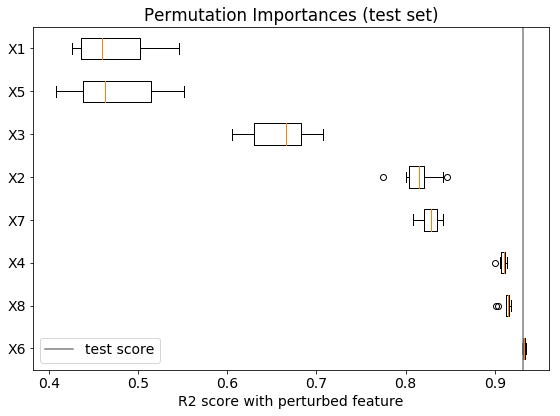

In [61]:
sorted_indcs = np.argsort(np.mean(scores,axis=1))[::-1]
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,6))
plt.boxplot(scores[sorted_indcs].T,labels=ftr_names[sorted_indcs],vert=False)
plt.axvline(test_score,label='test score' ,color='grey')
plt.title("Permutation Importances (test set)")
plt.xlabel('R2 score with perturbed feature')
plt.legend()
plt.tight_layout()
plt.show()

In [63]:
file = open('../../results/svr_grid_Y2.save', 'rb')
grid_2, X_test_2, y_test_2 = pickle.load(file)
file.close()

nr_runs = 10
ftr_names = X_test_2.columns
scores = np.zeros([len(ftr_names),nr_runs])

test_score = grid_2.score(X_test_2,y_test_2)
print('test score = ',test_score)
print('test baseline = 0')
# loop through the features
for i in range(len(ftr_names)):
    print('shuffling '+str(ftr_names[i]))
    r2_scores = []
    for j in range(nr_runs):b
        X_test_shuffled = X_test_2.copy()
        X_test_shuffled[ftr_names[i]] = np.random.permutation(X_test_2[ftr_names[i]].values)
        r2_scores.append(grid.score(X_test_shuffled,y_test_2))
    print('   shuffled test score:',np.around(np.mean(r2_scores),3),'+/-',np.around(np.std(r2_scores),3))
    scores[i] = r2_scores

test score =  0.8873825924109046
test baseline = 0
shuffling X1
   shuffled test score: 0.348 +/- 0.03
shuffling X2
   shuffled test score: 0.705 +/- 0.02
shuffling X3
   shuffled test score: 0.541 +/- 0.04
shuffling X4
   shuffled test score: 0.803 +/- 0.006
shuffling X5
   shuffled test score: 0.35 +/- 0.032
shuffling X6
   shuffled test score: 0.808 +/- 0.002
shuffling X7
   shuffled test score: 0.722 +/- 0.011
shuffling X8
   shuffled test score: 0.797 +/- 0.005


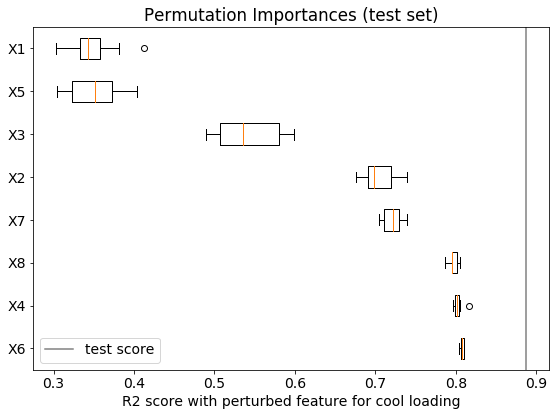

In [64]:
sorted_indcs = np.argsort(np.mean(scores,axis=1))[::-1]
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,6))
plt.boxplot(scores[sorted_indcs].T,labels=ftr_names[sorted_indcs],vert=False)
plt.axvline(test_score,label='test score' ,color='grey')
plt.title("Permutation Importances (test set)")
plt.xlabel('R2 score with perturbed feature for cool loading')
plt.legend()
plt.tight_layout()
plt.show()

### Multilayer Perceptron regression

In [60]:
from sklearn.neural_network import MLPRegressor

In [66]:
nnr = MLPRegressor(max_iter=10000,solver='sgd', 
                   activation='tanh', batch_size=100,
                   learning_rate='adaptive',
                   random_state=42, hidden_layer_sizes=[10,10])
# alphas = np.logspace(-3, 2, num=5)
alphas = [0.0001]
# # hls = [[10,10], [15,15], [20,20]]
hls = [[10,10]]
param_grid = { "regressor__alpha" : alphas, 
               "regressor__hidden_layer_sizes" : hls}

In [67]:
best_scores = []
best_params = []
for i in range(10):
    grid, test_score = ML_pipeline_GridSearchCV_kfold(X, y1, 
          seed=42*i, n_folds=5, reg=nnr, param_grid=param_grid)
    best_scores.append(test_score)
    best_params.append(grid.best_params_)

In [68]:
print("Mean of the best score is %.3f." % -np.mean(best_scores))
print("std of the best score is %.3f." % np.std(best_scores))

Mean of the best score is 0.344.
std of the best score is 0.071.


In [29]:
best_params

[{'regressor__alpha': 0.001, 'regressor__hidden_layer_sizes': [10, 10]}]

### Global feature importance